# 👣 The first step to the "generation"
We will be starting from very basic way to generate the stuff and then we will eventually build the GPT which can generate the documents.

The "makemore" is the term used by Andrej on his GitHub in which he builds the model where *"give any kind of data"* to the model and the model will be able to generate ***new*** data which looks like that data given but is unique and generated fresh from the oven for you. Hence, the term "makemore".

Fine, you already know the details, and if you prefer the video, it is [here](https://www.youtube.com/watch?v=PaCmpygFfXo).

Let's code.<br>
We will start by making more the NAMES of the human child.

## 🔠Character level?
Alright, what to expect? 

As seen in the [my last notebook](https://github.com/AayushSameerShah/Neural-Net-Zero-to-Hero-with-Andrej/blob/main/01%20-%20Micrograd/Micrograd%20Foundations.ipynb), I've implemented all code + intuition all in single file... which made sense in that regard, *but here* I will have to break things up a little.

The reason is **we will build up from the ground or from the simple generation** to the complex generation (GPT). So the generation will be split into:

- Bigram (simple - one character predicts the next one with a lookup table of counts)
- MLP
- RNN
- LSTM
- GRU
- Transformer (complex - *but easy*)

## 🆎 The Bigram
Here, we will predict the **single character** at a time **based upon** the previous single character. So, we won't care much about all other previous characters. This is the simplest approach but will get us going really easily.

So, after exploring this - we will start building the makemore with other methods such as MLP, RNN etc.

Let's get started with Bigram.

> 📜 <br>**Note** that Bigram can be made to predict the next word, instead of the next character. It is upon us which kind of granularity we want to use. Since we are starting with the *simplest* case, we will start with the character level prediction instead of the word level. <br><br>*(And also, when you just want to generate a single name - as in this case, then you don't want to predict the next word since there is a single word already in the name! Thus, it is the best case to use the character level token generation)*

In [1]:
# loading the dataset
with open("./names.txt", "r") as file:
    names = file.read().splitlines()

In [2]:
names[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
# The total names are...
len(names)

32033

In [4]:
# With minimum length
min(len(name) for name in names)

2

In [5]:
# With maximim length
max(len(name) for name in names)

15

### ✋ Now while generating...
We have a previous word, so we will generate the next word as well. For how long? In this way we will keep generating the word for infinite. To stop somewhere we will also need to indicate the some stop token which is a *special* character which doesn't appear in any name.

This is the most common mechanism in the text generation. There ***tokenizers*** usually have the "special tokens" like `<|stop|>` or `<|endoftext|>`. Which are given together in the training data, and where the model generates the text, and generates that stop token, the generation is terminated because the stop token is reached.

We will have to *define* the similar stop token here as well to generate some name which makes sense.

> Have a look at that clip: [here](https://youtube.com/clip/UgkxJdaK9WV8n1HChjmUF3DmekIAfNCROts3)

<iframe width="560" height="315" src="https://www.youtube.com/embed/PaCmpygFfXo?clip=UgkxJdaK9WV8n1HChjmUF3DmekIAfNCROts3&amp;clipt=EO3HERjn7xQ" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>

### Character combinations *(and permutations)*

For the bigram to work, we will need to figure out which characters appears together most often. Let's be some more pythonic and see that in action.

In [6]:
# Iterating through all names
for name in names[:5]:
    print("\n---", name, "---")
    
    # Iterating through all characters in a pair of 2 at a time
    for ch1, ch2 in zip(name, name[1:]):    
        print(ch1, "→", ch2)


--- emma ---
e → m
m → m
m → a

--- olivia ---
o → l
l → i
i → v
v → i
i → a

--- ava ---
a → v
v → a

--- isabella ---
i → s
s → a
a → b
b → e
e → l
l → l
l → a

--- sophia ---
s → o
o → p
p → h
h → i
i → a


Cool! **Should we now start counting?**. <br>
Nah! As said, we will need to implement some "STOP" token like `<|stop|>` or like `<S>` *(as shown in the lecture)*. But we will directly indicate the `<` and `>` as the stop token because it is used later in the lecture and is the "single" character.

#### A little check...
We need to check 2 things before proceeding:
1. Whether "<" and ">" are the part of any name
2. If all names are in the lower case

In [7]:
check1 = [("<" in name) or (">" in name) for name in names]
any(check1)

False

Good.

In [8]:
check2 = [name.lower() for name in names]
names = check2

Done.

In [9]:
# Iterating through all names
for name in names[:5]:
    print("\n---", name, "---")
    name = "<" + name + ">"
    # Iterating through all characters in a pair of 2 at a time
    for ch1, ch2 in zip(name, name[1:]):    
        print(ch1, "→", ch2)


--- emma ---
< → e
e → m
m → m
m → a
a → >

--- olivia ---
< → o
o → l
l → i
i → v
v → i
i → a
a → >

--- ava ---
< → a
a → v
v → a
a → >

--- isabella ---
< → i
i → s
s → a
a → b
b → e
e → l
l → l
l → a
a → >

--- sophia ---
< → s
s → o
o → p
p → h
h → i
i → a
a → >


Making the counter.

In [10]:
counter = {}

for name in names[:5]:
    name = "<" + name + ">"    
    for ch1, ch2 in zip(name, name[1:]):    
        bigram = (ch1, ch2)
        counter[bigram] = counter.get(bigram, 0) + 1

In [11]:
counter

{('<', 'e'): 1,
 ('e', 'm'): 1,
 ('m', 'm'): 1,
 ('m', 'a'): 1,
 ('a', '>'): 5,
 ('<', 'o'): 1,
 ('o', 'l'): 1,
 ('l', 'i'): 1,
 ('i', 'v'): 1,
 ('v', 'i'): 1,
 ('i', 'a'): 2,
 ('<', 'a'): 1,
 ('a', 'v'): 1,
 ('v', 'a'): 1,
 ('<', 'i'): 1,
 ('i', 's'): 1,
 ('s', 'a'): 1,
 ('a', 'b'): 1,
 ('b', 'e'): 1,
 ('e', 'l'): 1,
 ('l', 'l'): 1,
 ('l', 'a'): 1,
 ('<', 's'): 1,
 ('s', 'o'): 1,
 ('o', 'p'): 1,
 ('p', 'h'): 1,
 ('h', 'i'): 1}

Here we can see that the `('a', '>'): 5` has the highest count. So, most of the time the name ends with the `a` latter.

In [12]:
# For all words
counter = {}

for name in names:
    name = "<" + name + ">"    
    for ch1, ch2 in zip(name, name[1:]):    
        bigram = (ch1, ch2)
        counter[bigram] = counter.get(bigram, 0) + 1

Some inspection...

In [13]:
counter_sorted = sorted(counter.items(), 
                        key=lambda kv:kv[1],
                        reverse=True)

In [14]:
counter_sorted[:5]

[(('n', '>'), 6763),
 (('a', '>'), 6640),
 (('a', 'n'), 5438),
 (('<', 'a'), 4410),
 (('e', '>'), 3983)]

Now we can see that `('n', '>'), 6763)` is the most common ending for the name! And also ` (('<', 'a'), 4410)` is the most common starting of the name! 

> So, in some case if you name is "Alien" then don't be surprised! You are one of us 👽

## 📊 Visual inspection

Whatever Andrej follows in the code is simple and fast, but I would like to do it in other way because of my lazyness. I will use Pandas. At least for this code.

In [15]:
import pandas as pd
df = pd.DataFrame(counter.values(), index=counter.keys(), columns=["Counts"])

In [16]:
counts_2D = df.unstack().fillna(0)
counts_2D = counts_2D.droplevel(0, axis=1)

Vizzing...

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

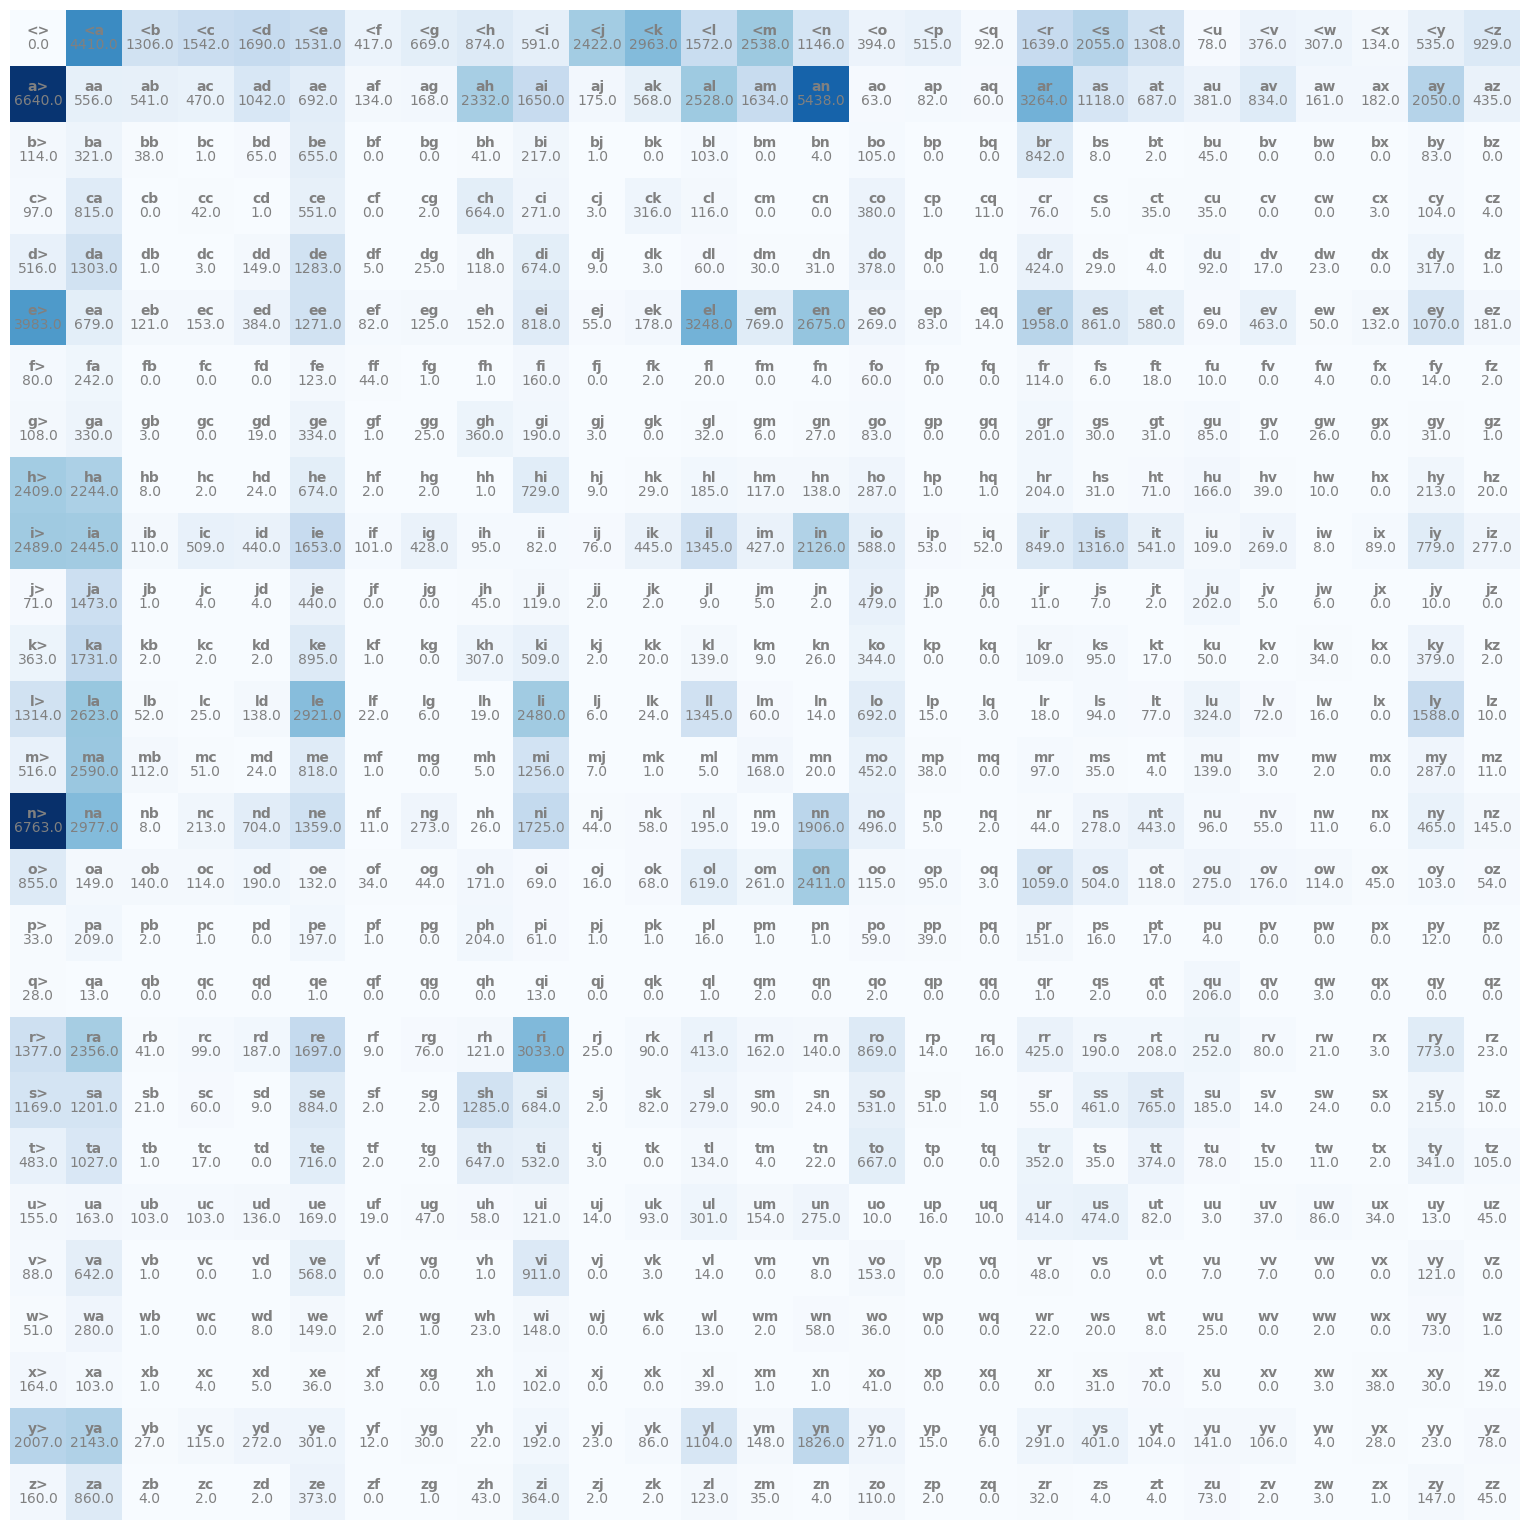

In [18]:
plt.figure(figsize=(20, 20), dpi=100)
plt.imshow(counts_2D, cmap="Blues")
for i, ch1 in enumerate(counts_2D.index):
    for j, ch2 in enumerate(counts_2D.columns):
        chstr = ch1 + ch2
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray", weight='bold')
        plt.text(j, i, counts_2D.iloc[i, j], ha="center", va="top", color="gray")
plt.axis("off");

A lot of analysis can be carried out from this pretty heatmap:
- Top most starting letters are `a` and `k`
- Top most ending letters are `a`, `n` and `e`
- There are many combinations like `tq`, `qn`, `sx` have the 0 occurances.
- The least common ending letter is `q`.

etc.

## Making more!
Great, now we have all the counts so we will be able to generate the names. 

For that we will need to rely on the probability. So, the following steps:
1. Start with a latter - this will be "sampled" from the first row of our 2D matrix since they indicate the first latter.
2. For the sampling we will use the their individual probabilities. 
3. Once the first character is sampled, we will sample the next character **based** upon the first character and to do that we will sample from the row from 2D matrix for *that* first character
4. Repeat these 2-3 steps **until** the end-of-generation is sampled. Which is the `>` character.
5. Done.

This is really simplistic. We will see how that goes.

### Again!
> I will try to use the `np` for this. Because in the video, Andrej uses pytorch but I think if the same thing can be done with some "known" library, then why not? 

Of course, by using the pytorch you will get the chance to get fimiliarized with the library, which in turn will help you in the later part... but for now I think we don't need to do that. Let's stick with our same old school ***numpy*** 😍

In [19]:
import numpy as np

In [20]:
# This will give us the counts for the first latter
counts_2D.iloc[0]

>       0.0
a    4410.0
b    1306.0
c    1542.0
d    1690.0
e    1531.0
f     417.0
g     669.0
h     874.0
i     591.0
j    2422.0
k    2963.0
l    1572.0
m    2538.0
n    1146.0
o     394.0
p     515.0
q      92.0
r    1639.0
s    2055.0
t    1308.0
u      78.0
v     376.0
w     307.0
x     134.0
y     535.0
z     929.0
Name: <, dtype: float64

In [21]:
# Converting into the probabilities
counts_2D.iloc[0] / counts_2D.iloc[0].sum()

>    0.000000
a    0.137671
b    0.040770
c    0.048138
d    0.052758
e    0.047794
f    0.013018
g    0.020885
h    0.027284
i    0.018450
j    0.075610
k    0.092498
l    0.049074
m    0.079231
n    0.035776
o    0.012300
p    0.016077
q    0.002872
r    0.051166
s    0.064153
t    0.040833
u    0.002435
v    0.011738
w    0.009584
x    0.004183
y    0.016702
z    0.029001
Name: <, dtype: float64

Now we are all set **to use** these probabilities to sample the character. <br>
For example...

In [22]:
# For the same random number generation
seed = np.random.RandomState(42)

# Converting into the probabilities
p = counts_2D.iloc[0] / counts_2D.iloc[0].sum()
seed.choice(p.index, p=p)

'h'

See? It returns a character from the sequence based upon the probability.

In [23]:
p.sort_values(ascending=False)[:5]

a    0.137671
k    0.092498
m    0.079231
j    0.075610
s    0.064153
Name: <, dtype: float64

Have a look, we have `a` occuring most of the time as the **first** character, which means if we sample `100` characters from this probability, then there will be `a` occuring for `13` times and `k` for `9` times and so on.

Wanna try that?

In [24]:
samples = seed.choice(p.index, p=p, size=100)
samples

array(['x', 'n', 'l', 'b', 'b', 'a', 's', 'l', 'n', 'a', 'y', 's', 'c',
       'c', 'c', 'e', 'k', 'j', 'e', 'l', 'b', 'e', 'h', 'j', 'r', 'c',
       'k', 'l', 'a', 'l', 'b', 'a', 'w', 'y', 'r', 'e', 'a', 'm', 'j',
       'a', 'k', 'a', 't', 'd', 'm', 'e', 'k', 'k', 'c', 'y', 'r', 'v',
       't', 'l', 't', 'a', 'c', 'a', 'e', 'i', 'd', 's', 'g', 'e', 'k',
       'b', 'r', 'a', 'z', 'r', 'c', 'a', 'r', 'n', 'n', 'r', 'a', 'g',
       'a', 's', 'l', 'f', 'a', 'e', 'e', 'n', 'm', 't', 'j', 'a', 'n',
       'p', 'k', 'r', 'k', 'k', 'j', 'a', 'a', 'a'], dtype=object)

In [25]:
pd.value_counts(samples)[:5]

a    18
k     9
e     9
r     8
l     7
dtype: int64

Alright, for 100 we are not confirming the perfect sampling as expected but if we do it for sat 10,000 then it will follow the `p` given. Try it out!

In [26]:
samples = seed.choice(p.index, p=p, size=10_000)
pd.value_counts(samples)[:5]

a    1419
k     950
m     800
j     765
s     620
dtype: int64

Done! See!?

### Alright, let's get back to the business.
Now we know how it works... let's make a loop to do that for us.
We will start with a single name generation first.

In [27]:
# Starting distribution
seed = np.random.RandomState(42)
p = counts_2D.iloc[0] / counts_2D.iloc[0].sum()

# Sampling first character
ch = seed.choice(p.index, p=p)

# new name
new_name = [ch]

while (ch != ">"):
    # Get the distribution of for the `ch` to sample next character 
    p = counts_2D.loc[ch] / counts_2D.loc[ch].sum()
    ch = seed.choice(p.index, p=p)
    new_name.append(ch)

In [28]:
''.join(new_name)

'huria>'

Yo! The first name generation!! <br>
Let's generate some more...!

In [29]:
# Starting distribution
seed = np.random.RandomState(42)
new_names = []

for i in range(20):
    p = counts_2D.iloc[0] / counts_2D.iloc[0].sum()

    # Sampling first character
    ch = seed.choice(p.index, p=p)

    # new name
    new_name = [ch]

    while (ch != ">"):
        # Get the distribution of for the `ch` to sample next character 
        p = counts_2D.loc[ch] / counts_2D.loc[ch].sum()
        ch = seed.choice(p.index, p=p)
        new_name.append(ch)
        
    new_names.append(''.join(new_name)[:-1]) # to remove `>`

In [30]:
new_names

['huria',
 'atin',
 'yn',
 'cahakan',
 'eigoffi',
 'la',
 'wyn',
 'ana',
 'k',
 'tan',
 'ke',
 'ynttivaa',
 'ekaseelar',
 'zla',
 'rior',
 'gatle',
 'eflith',
 'nillele',
 'a',
 'malyaipa']

## WOO! We are doing it man! 🎉
But hey! This is **reallly** the simplest model. It only cares about the previous latter. So many names are just the garbage and rubbish. But still, some names like `ana`, `atin`, `huria` are pretty realistic! 😱

### Just to entertain the possiblity...
The *thing* we just saw above is from the "trained" model, because in which we "learned" the counts from the training data and then the choice is coming from the distribution. But in the case of "un trained" model in which all `p` values are uniform... we would get this...

In [31]:
# Starting distribution
seed = np.random.RandomState(42)
new_names = []

for i in range(20):
    p = counts_2D.iloc[0] / counts_2D.iloc[0].sum()

    # Sampling first character
    ch = seed.choice(p.index) ## REMOVED `p=p`

    # new name
    new_name = [ch]

    while (ch != ">"):
        # Get the distribution of for the `ch` to sample next character 
        p = counts_2D.loc[ch] / counts_2D.loc[ch].sum()
        ch = seed.choice(p.index) ## REMOVED `p=p`
        new_name.append(ch)
        
    new_names.append(''.join(new_name)[:-1]) # to remove `>`

In [32]:
new_names

['fsnjgtfyrvjjwtcgwbutawkeat',
 'kyukxpzzionnrkvsxbdrfthfqcxmqyhytasnfkgnbmpcqgcaeuicuqykaicmongmvxgtolqntwyxlhnl',
 'xfhw',
 'kgwjrpgbb',
 'zdifyhfhgka',
 'ovvwdbkguzb',
 'bdnmb',
 'dyvmfzhnnyilrfpscdvflnjclfzruailxtekksjyvxf',
 '',
 'xzxslhbfegzhd',
 'rikwnzuwhsppyskfabpdpwpzpaauvd',
 '',
 'ratkyevcvjwzpewdsaeujoo',
 'hzeobszcrybrsfsh',
 'gfqg',
 'jxxqvibfoyoxspa',
 'okddzvhhbroobswuw',
 'wsjpgcegsboxbxqmqaubohc',
 'c',
 'mtoswgfbp']

Wow! This is coming from the un-trained model, in which it just randomly picks up the characters.

## Moving on...
We will create a "ready `p`" table to reference to so that in predicting each character, **we don't have to** calculate the probabilities again. So, just the `counter_2D` as is, but full of probabilities.

In [33]:
counts_2D_P = counts_2D.divide(counts_2D.sum(1), axis='index')
counts_2D_P

,>,a,b,c,d,e,f,g,h,i,...,q,r,s,t,u,v,w,x,y,z
<,0.000000,0.137671,0.040770,0.048138,0.052758,0.047794,0.013018,0.020885,0.027284,0.018450,...,0.002872,0.051166,0.064153,0.040833,0.002435,0.011738,0.009584,0.004183,0.016702,0.029001
a,0.195957,0.016408,0.015966,0.013870,0.030751,0.020422,0.003955,0.004958,0.068821,0.048694,...,0.001771,0.096326,0.032994,0.020274,0.011244,0.024613,0.004751,0.005371,0.060499,0.012838
b,0.043100,0.121361,0.014367,0.000378,0.024575,0.247637,0.000000,0.000000,0.015501,0.082042,...,0.000000,0.318336,0.003025,0.000756,0.017013,0.000000,0.000000,0.000000,0.031380,0.000000
c,0.027463,0.230747,0.000000,0.011891,0.000283,0.156002,0.000000,0.000566,0.187995,0.076727,...,0.003114,0.021518,0.001416,0.009909,0.009909,0.000000,0.000000,0.000849,0.029445,0.001133
d,0.093886,0.237082,0.000182,0.000546,0.027111,0.233443,0.000910,0.004549,0.021470,0.122635,...,0.000182,0.077147,0.005277,0.000728,0.016739,0.003093,0.004185,0.000000,0.057678,0.000182
e,0.195025,0.033247,0.005925,0.007492,0.018802,0.062234,0.004015,0.006121,0.007443,0.040053,...,0.000686,0.095872,0.042158,0.028399,0.003379,0.022671,0.002448,0.006463,0.052392,0.008863
f,0.088398,0.267403,0.000000,0.000000,0.000000,0.135912,0.048619,0.001105,0.001105,0.176796,...,0.000000,0.125967,0.006630,0.019890,0.011050,0.000000,0.004420,0.000000,0.015470,0.002210
g,0.056046,0.171251,0.001557,0.000000,0.009860,0.173326,0.000519,0.012974,0.186819,0.098599,...,0.000000,0.104307,0.015568,0.016087,0.044110,0.000519,0.013492,0.000000,0.016087,0.000519
h,0.316308,0.294643,0.001050,0.000263,0.003151,0.088498,0.000263,0.000263,0.000131,0.095720,...,0.000131,0.026786,0.004070,0.009322,0.021796,0.005121,0.001313,0.000000,0.027967,0.002626
i,0.140614,0.138128,0.006214,0.028755,0.024857,0.093385,0.005706,0.024179,0.005367,0.004633,...,0.002938,0.047963,0.074346,0.030563,0.006158,0.015197,0.000452,0.005028,0.044009,0.015649


Perfect.

### Let's generate more...

In [34]:
# Starting distribution
seed = np.random.RandomState(42)
new_names = []

for i in range(20):
    p = counts_2D_P.iloc[0] # Just reference it! No re-calculation!

    # Sampling first character
    ch = seed.choice(p.index, p=p)

    # new name
    new_name = [ch]

    while (ch != ">"):
        # Get the distribution of for the `ch` to sample next character 
        p = counts_2D_P.loc[ch]
        ch = seed.choice(p.index, p=p)
        new_name.append(ch)
        
    new_names.append(''.join(new_name)[:-1]) # to remove `>`

In [35]:
new_names

['huria',
 'atin',
 'yn',
 'cahakan',
 'eigoffi',
 'la',
 'wyn',
 'ana',
 'k',
 'tan',
 'ke',
 'ynttivaa',
 'ekaseelar',
 'zla',
 'rior',
 'gatle',
 'eflith',
 'nillele',
 'a',
 'malyaipa']

Same! Wow!
I want to make more!!!!

In [36]:
seed = np.random.RandomState(1)
new_names = []

for i in range(100):
    p = counts_2D_P.iloc[0] # Just reference it! No re-calculation!
    ch = seed.choice(p.index, p=p)
    new_name = [ch]

    while (ch != ">"):
        p = counts_2D_P.loc[ch] # Just reference it! No re-calculation!
        ch = seed.choice(p.index, p=p)
        new_name.append(ch)
        
    new_names.append(''.join(new_name)[:-1])

In [37]:
new_names

['ji',
 'e',
 'a',
 'gelen',
 's',
 'mamaaryanno',
 'a',
 's',
 'junidis',
 'oyn',
 'r',
 'jolda',
 'made',
 'kani',
 'jha',
 'kilyly',
 'bre',
 'ukiosiomaveyne',
 'wemacon',
 'lelyavi',
 'viza',
 'vi',
 'poura',
 'a',
 'drilpaemyl',
 'rareson',
 'a',
 'a',
 'cke',
 'ayladkanyn',
 'khla',
 'alileylemin',
 'ahear',
 'doenaxa',
 'nkuv',
 'dhuwiurelilysey',
 'a',
 'k',
 'wo',
 'be',
 'reylustharali',
 'lerdriari',
 'jev',
 'zayloneemisorrenaielenayn',
 'jarstolashkephilei',
 'h',
 'zarrilalean',
 'tue',
 'chiadren',
 'ale',
 'lin',
 'pami',
 'esshovis',
 'minn',
 'rladiererya',
 'tiylyli',
 'g',
 'br',
 'hnin',
 'jey',
 'dargalarcannarilyn',
 'nayad',
 'jannireshlia',
 'a',
 'ja',
 'perelelono',
 'ran',
 'k',
 'xxtva',
 'citzioula',
 'aradolyamavelix',
 'no',
 'kashelic',
 'lelybeivrque',
 'da',
 'leran',
 'ka',
 'dike',
 'kyneyri',
 'a',
 'jay',
 'zlongh',
 'ghiiga',
 'peyaharh',
 'elira',
 'ko',
 'migtn',
 'kosindamiesararereardioh',
 'cai',
 'ann',
 'dawileshrikay',
 'cha',
 'n',
 'mia

Many, many names ***are*** actually names! This really is cool.

Now, of course, if we had some other dataset to train on, it would do that and the results will be different *(say a dataset on the names of research papers or scientific jargons or even the medical terms!)*.

# 🧪 Evaluation.
This is the big thing. In other problems such as regression or classification we have the labels, and we get some sense of what is being predicted and how better it is being predicted. But in the "case of generation" how can we possibly do so?

___

We have a model (with the calculated probabilities, the counts - by hand of course) so now we can get see **how well this (bigram model) performs** on the training data. So for that we will have a look at the probabilities.

In [38]:
# Let's have a look at the first 5 names
for name in names[:5]:
    print("\n---", name, "---")
    name = "<" + name + ">"
    for ch1, ch2 in zip(name, name[1:]):    
        p = counts_2D_P.loc[ch1, ch2]
        print(ch1, "→", ch2, f": {p=:.4f}")


--- emma ---
< → e : p=0.0478
e → m : p=0.0377
m → m : p=0.0253
m → a : p=0.3899
a → > : p=0.1960

--- olivia ---
< → o : p=0.0123
o → l : p=0.0780
l → i : p=0.1777
i → v : p=0.0152
v → i : p=0.3541
i → a : p=0.1381
a → > : p=0.1960

--- ava ---
< → a : p=0.1377
a → v : p=0.0246
v → a : p=0.2495
a → > : p=0.1960

--- isabella ---
< → i : p=0.0184
i → s : p=0.0743
s → a : p=0.1482
a → b : p=0.0160
b → e : p=0.2476
e → l : p=0.1590
l → l : p=0.0964
l → a : p=0.1879
a → > : p=0.1960

--- sophia ---
< → s : p=0.0642
s → o : p=0.0655
o → p : p=0.0120
p → h : p=0.1988
h → i : p=0.0957
i → a : p=0.1381
a → > : p=0.1960


These are the *probabilities* for predicting the next word, and the **higher it is, the better the model is at predicting the next token**. In some cases we can see that the probabilities are high like `39%`, `20%` and so on... but in the case of "a really really good model" we would have got some probabilities near to 100% (of course not 100%.)

But this was just about this first 5 names... and to **summarize** it in **the single number** on which we could then improve the model, we need some aggregation. And in this case of probability we will `multiply` all the probabilities - called: ***Likelihood***.

### But here we may have the problem.
Multiplying the probabilities (which are between 0 - 1) we will end up looking at very small number which may suffer from the memory overflow issues. The alternative could be to multiply the probabilities with 100 and then perform the multiplication... So, this should be very high. 

But *people* like to perform the ***log likelihood***.

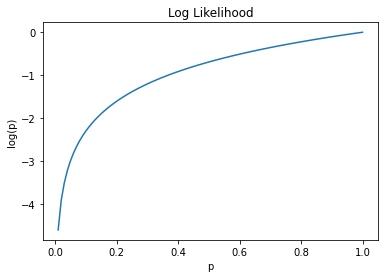

In [39]:
p = np.linspace(0.01, 1, num=100)
log_p = np.log(p)
plt.plot(p, log_p)
plt.xlabel("p")
plt.ylabel("log(p)")
plt.title("Log Likelihood");

The `log` has a property that the closer you are to the `0` the **more negative** the log(p) becomes and the `1.0`'s  log is `0.0`. Which means log can never be positive.

- Here, if we need to minimize the loss, then **we will have to maximize the log-likelihood**
- But as we know, loss function has the tendency to "minimize" the number. So, the negative becomes more negative *(if we have taken just the log-likelihood)*
- So, we **simply make it positive**!

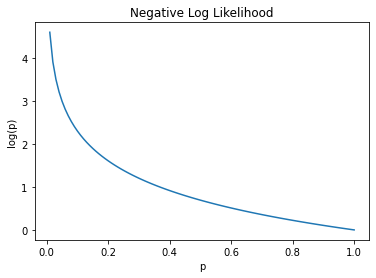

In [40]:
p = np.linspace(0.01, 1, num=100)
log_p = np.log(p)
plt.plot(p, -log_p)
plt.xlabel("p")
plt.ylabel("log(p)")
plt.title("Negative Log Likelihood");

Now! We **have found our pretty loss function!**. <br>
If the neg-log-likelihood is high, it means we are performing poor *(because it comes from the low p → which leads to more negative log → which leads to high log because of the positive casting)*

Let's just calculate it for our 5 names.

In [41]:
# Let's have a look at the first 5 names
for name in names[:5]:
    print("\n---", name, "---")
    name = "<" + name + ">"
    for ch1, ch2 in zip(name, name[1:]):    
        p = counts_2D_P.loc[ch1, ch2]
        neg_log = -np.log(p)
        print(ch1, "→", ch2, f": {p=:.3f}\t{neg_log=:.3f}", )


--- emma ---
< → e : p=0.048	neg_log=3.041
e → m : p=0.038	neg_log=3.279
m → m : p=0.025	neg_log=3.677
m → a : p=0.390	neg_log=0.942
a → > : p=0.196	neg_log=1.630

--- olivia ---
< → o : p=0.012	neg_log=4.398
o → l : p=0.078	neg_log=2.551
l → i : p=0.178	neg_log=1.728
i → v : p=0.015	neg_log=4.187
v → i : p=0.354	neg_log=1.038
i → a : p=0.138	neg_log=1.980
a → > : p=0.196	neg_log=1.630

--- ava ---
< → a : p=0.138	neg_log=1.983
a → v : p=0.025	neg_log=3.704
v → a : p=0.250	neg_log=1.388
a → > : p=0.196	neg_log=1.630

--- isabella ---
< → i : p=0.018	neg_log=3.993
i → s : p=0.074	neg_log=2.599
s → a : p=0.148	neg_log=1.909
a → b : p=0.016	neg_log=4.137
b → e : p=0.248	neg_log=1.396
e → l : p=0.159	neg_log=1.839
l → l : p=0.096	neg_log=2.340
l → a : p=0.188	neg_log=1.672
a → > : p=0.196	neg_log=1.630

--- sophia ---
< → s : p=0.064	neg_log=2.746
s → o : p=0.066	neg_log=2.726
o → p : p=0.012	neg_log=4.425
p → h : p=0.199	neg_log=1.615
h → i : p=0.096	neg_log=2.346
i → a : p=0.138	neg_log

### Still not the single number?
Yes, we just converted the `p`→ `log` → `-log` but still the multiplication isn't done. 

> 🚨 <br>**NOTE**: Since we have converted the `p` into `log` the following is equal: <br>
$log(p1 * p2 * p3) == log(p1) + log(p2) + log(p3)$

Thus, no multiplication! Just the addition!

In [42]:
log_likelihood = 0.0

for name in names[:5]:
    name = "<" + name + ">"
    for ch1, ch2 in zip(name, name[1:]):    
        p = counts_2D_P.loc[ch1, ch2].round(3)
        neg_log = -np.log(p).round(3)
        log_likelihood += neg_log

In [43]:
log_likelihood

77.805

Or alternatively we can get the `average` of this log_likelihood...

In [44]:
log_likelihood = 0.0
n = 0 # counter for the bigrams calculated

for name in names[:5]:
    name = "<" + name + ">"
    for ch1, ch2 in zip(name, name[1:]):    
        p = counts_2D_P.loc[ch1, ch2].round(3)
        neg_log = -np.log(p).round(3)
        log_likelihood += neg_log
        n += 1

log_likelihood / n

2.43140625

#### A small issue...

In [45]:
for name in ["aayush"]:
    print("\n---", name, "---")
    name = "<" + name + ">"
    for ch1, ch2 in zip(name, name[1:]):    
        p = counts_2D_P.loc[ch1, ch2]
        neg_log = -np.log(p)
        print(ch1, "→", ch2, f": {p=:.3f}\t{neg_log=:.3f}", )


--- aayush ---
< → a : p=0.138	neg_log=1.983
a → a : p=0.016	neg_log=4.110
a → y : p=0.060	neg_log=2.805
y → u : p=0.014	neg_log=4.239
u → s : p=0.151	neg_log=1.889
s → h : p=0.159	neg_log=1.842
h → > : p=0.316	neg_log=1.151


In my name it works correctly... but if there are some "bigrams" which have `0` count... then the log will be `inf`

In [46]:
for name in ["aayushtk"]:
    print("\n---", name, "---")
    name = "<" + name + ">"
    for ch1, ch2 in zip(name, name[1:]):    
        p = counts_2D_P.loc[ch1, ch2]
        neg_log = -np.log(p)
        print(ch1, "→", ch2, f": {p=:.3f}\t{neg_log=:.3f}", )


--- aayushtk ---
< → a : p=0.138	neg_log=1.983
a → a : p=0.016	neg_log=4.110
a → y : p=0.060	neg_log=2.805
y → u : p=0.014	neg_log=4.239
u → s : p=0.151	neg_log=1.889
s → h : p=0.159	neg_log=1.842
h → t : p=0.009	neg_log=4.675
t → k : p=0.000	neg_log=inf
k → > : p=0.072	neg_log=2.631


C:\Users\aayus\AppData\Local\Temp\ipykernel_5952\3345603499.py:6: RuntimeWarning: divide by zero encountered in log
  neg_log = -np.log(p)


Here, `tk` has the `0` probability to occur. So... a dirty fix is to "smooth" the model out... by adding `+1`  to the count.

In [47]:
counts_2D = counts_2D + 1
counts_2D_P = counts_2D.divide(counts_2D.sum(1), axis='index')

Now, no issues.

In [48]:
for name in ["aayushtk"]:
    print("\n---", name, "---")
    name = "<" + name + ">"
    for ch1, ch2 in zip(name, name[1:]):    
        p = counts_2D_P.loc[ch1, ch2]
        neg_log = -np.log(p)
        print(ch1, "→", ch2, f": {p=:.3f}\t{neg_log=:.3f}", )


--- aayushtk ---
< → a : p=0.138	neg_log=1.984
a → a : p=0.016	neg_log=4.109
a → y : p=0.060	neg_log=2.805
y → u : p=0.014	neg_log=4.235
u → s : p=0.150	neg_log=1.896
s → h : p=0.158	neg_log=1.844
h → t : p=0.009	neg_log=4.665
t → k : p=0.000	neg_log=8.630
k → > : p=0.072	neg_log=2.633


Done! <br>
Now we are all ready to set-up for calculating the loss over whole dataset.

In [49]:
log_likelihood = 0.0
n = 0

for name in names:
    name = "<" + name + ">"
    for ch1, ch2 in zip(name, name[1:]):    
        p = counts_2D_P.loc[ch1, ch2]
        neg_log = -np.log(p)
        log_likelihood += neg_log
        n += 1

In [50]:
print(f"{log_likelihood=:.3f}\n{log_likelihood/n=:.3f}")

log_likelihood=560001.883
log_likelihood/n=2.455


### We cool!

# Next book!
As said, this bigram is the very first step in making the GPT. So, making all of them in the single book won't be a feasible thing. So, instead we will continue from the next book where we will start building the ***same*** thing but using the neural nets. And this time we will use the pytorch possibly!